# PW11 - Deep Q-Network
Objective: write the DQN algorithm and apply the corresponding policy to an [environment](https://gym.openai.com/envs/#classic_control) provided by Gym. In the following, we choose the CartPole environment, but feel free to change

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random

To render gym environment into colab

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip3 install xvfbwrapper
!pip3 install gym pyvirtualdisplay > /dev/null 2>&1

  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-cp37-none-any.whl size=5009 sha256=4ebee8102dd013defe3e84fb0a1a83b5c8063807d0bfe0ed67dc0254070e57b4
  Stored in directory: /root/.cache/pip/wheels/10/f2/61/cacfaf84b352c223761ea8d19616e3b5ac5c27364da72863f0
Successfully built xvfbwrapper


In [ ]:
from pyvirtualdisplay import Display
from IPython import display

d = Display()
d.start() 
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50) 

[50]

## Description of the problem

A pole is attached by an joint to a cart, moving along a frictionless track. 

The continuous state space $S$ is  a 4-D dimensional space, composed of:
- an $x$ coordinate for location, in [-4.8,4.8], 
- the velocity of the cart in $\mathbb{R}$, 
- the angle of the pole in [-24,24],
- the velocity at the tip of the pole in $\mathbb{R}$. 

The action space is of size 2: applying a force of +1 or -1 to the cart (the actions)

The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. 

We assume that we have achieved our goal if the average of the total reward is greater than 195 for 5 consecutive episodes


## How does the system behave with a random agent ?

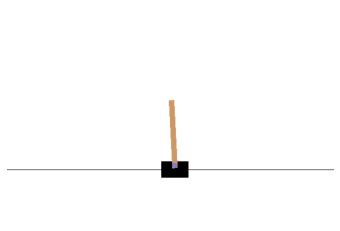

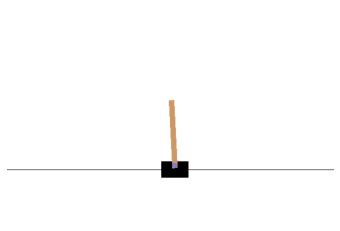

In [ ]:
o = envCartPole.reset()
img = plt.imshow(envCartPole.render('rgb_array'))
for t in range(100):
  display.clear_output(wait=True)
  img.set_data(envCartPole.render('rgb_array'))
  plt.axis('off')
  display.display(plt.gcf())  
  a = envCartPole.action_space.sample()
  o,r,done,info = envCartPole.step(a)

  if done:
    o = envCartPole.reset()
envCartPole.close()

In [ ]:
#Global Variables
nb_episodes = 200
nb_end_training = 0
limit_time = 250

In [ ]:
#Hyper Parameters
discount_rate = 0.95
batch_size = 24 # batch size for episode replay

In [ ]:
#Success parameters
reward_threshold = 195
consecutive_wins = 5

## DQN Class  
Creates a DQN object with the following methods:

- init: initilization of the model parameters
- build_model : build the neural network approximating $Q$
- action: generates the action.  using either exploration ($\epsilon$-greedy) or exploitation (generation using the network)
- test_action: generate the action in the test phase (only exploitation)
- store: save the observables 
- experience_replay: use experience replay strategy to predict the optimal action with the network using a batch os samples in the memory  

In [ ]:
class DQN():
    def __init__(self, states, actions, gamma, epsilon=1,epsilon_min=0.001, epsilon_decay=0.999):
        self.nb_states = states
        self.nb_actions = actions
        self.memory = deque([], maxlen=2500) # double-ended queue to manage the memory for the experience replay
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # Q approximation
        self.model = self.build_model()
        self.loss = []
        
    def build_model(self):
        model = Sequential() 
        model.add(Dense(24, input_dim=self.nb_states, activation='relu'))     
        model.add(Dense(24, activation='relu')) 
        model.add(Dense(self.nb_actions, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001)) 
        return model

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nb_actions) #Explore
        action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nb_states)) #States
        nst = np.zeros( (0,self.nb_states) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nb_states)
        y_reshape = np.array(y)
        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
#Create the agent
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn = DQN(nS, nA, discount_rate, 1, 0.001, 0.995)


In reinforcement learning, training occurs alongside the agent's acting in the environment; an episode refers to a sequence of actions that ends in some terminal state, such as the pole falling down or the cart crashing. The agent will need to remember all of its observations and actions, such that once an episode ends, it can learn to "reinforce" the good actions and punish the undesirable actions via training

In [ ]:
#Training
rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
nb_test_episodes = 0
for e in range(nb_episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    for time in range(limit_time): 
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell. 
        #time == limit_time - 1: CartPole stayed upright
        if done or time == limit_time - 1:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, nb_episodes, tot_rewards, dqn.epsilon))
            break
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    #Test if success
    if len(rewards) > consecutive_wins and np.average(rewards[-consecutive_wins:]) > reward_threshold:
        #Set the rest of the nb_episodes for testing
        nb_test_episodes = nb_episodes - e
        nb_end_training = e
        break

episode: 0/200, score: 16.0, e: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


episode: 1/200, score: 11.0, e: 0.990025
episode: 2/200, score: 35.0, e: 0.8348931673187264
episode: 3/200, score: 12.0, e: 0.7901049725470279
episode: 4/200, score: 10.0, e: 0.7552531090661897
episode: 5/200, score: 10.0, e: 0.7219385759785162
episode: 6/200, score: 24.0, e: 0.6433260027715241
episode: 7/200, score: 11.0, e: 0.6118738784280476
episode: 8/200, score: 12.0, e: 0.5790496471185967
episode: 9/200, score: 9.0, e: 0.5562889678716474
episode: 10/200, score: 13.0, e: 0.5238143793828016
episode: 11/200, score: 13.0, e: 0.4932355662165453
episode: 12/200, score: 11.0, e: 0.46912134373457726
episode: 13/200, score: 9.0, e: 0.4506816115185697
episode: 14/200, score: 8.0, e: 0.4351424010585501
episode: 15/200, score: 21.0, e: 0.3936343764094253
episode: 16/200, score: 9.0, e: 0.37816180712868996
episode: 17/200, score: 9.0, e: 0.3632974174544486
episode: 18/200, score: 10.0, e: 0.3472722151889232
episode: 19/200, score: 14.0, e: 0.3253644408394192
episode: 20/200, score: 10.0, e: 0

In [ ]:
#dqn.model.save('dqn.h5')
#Once trained...
dqn.model = load_model('dqn.h5')

KeyboardInterrupt: ignored

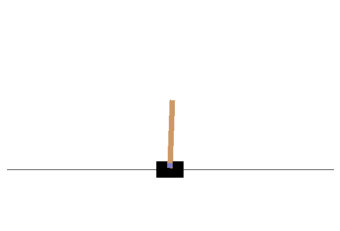

In [ ]:
from PIL import Image
#Test the agent that was trained
env_vis=[]
nb_test_episodes = 10
from gym.wrappers import Monitor


for e_test in range(nb_test_episodes):
 
    state = envCartPole.reset()
    img = plt.imshow(envCartPole.render('rgb_array'))


    state = np.reshape(state, [1,nS  ])
    tot_rewards = 0
    for t_test in range(210):
        display.clear_output(wait=True)
        img.set_data(envCartPole.render('rgb_array'))
        plt.axis('off')
        #im = Image.fromarray(envCartPole.render('rgb_array'))
        #im.save('imag_{:04d}_{:04d}.png'.format(e_test,t_test))

       
        display.display(plt.gcf())
        
        action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        state = nstate
        #done: CartPole fell. 
        #t_test == limit_time - 1 : CartPole stayed upright
        if done or t_test == limit_time - 1: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, nb_test_episodes, tot_rewards, 0))
            break;
        if d:
          envCartPole.reset()

        
    envCartPole.close()

In [ ]:
anim_file = 'cartPole.gif'
import imageio
import glob


with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('imag*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
# to be done 1 time
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.

**Results**  
Here is a graph of the results. If everything was done correctly you should see the rewards over the red line.  

Blue: This is the reward for each episode  
Green: This is the value of epsilon scaled by 200  
Yellow: tests started.

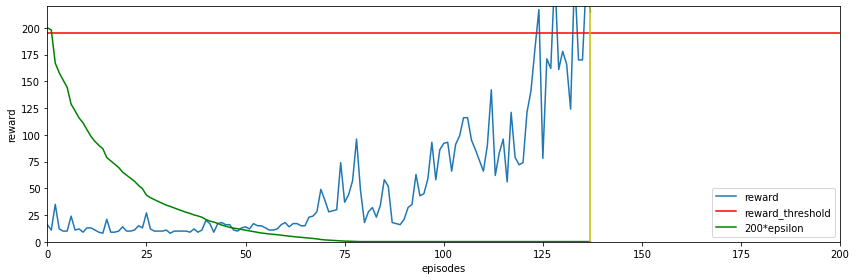

In [ ]:
rolling_average = np.convolve(rewards, np.ones(100)/100)
plt.figure(figsize=(12,4))
plt.plot(rewards,label='reward')
plt.axhline(y=reward_threshold, color='r', linestyle='-',label='reward_threshold') 
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-',label='200*epsilon')
#Plot the line where TESTING begins
plt.axvline(x=nb_end_training, color='y', linestyle='-')
plt.xlim( (0,nb_episodes) )
plt.xlabel('episodes')
plt.ylim( (0,220) )
plt.ylabel('reward')
plt.legend(loc='best')
plt.tight_layout()

envCartPole.close()

**Changes**  
*hyper parameters*: You can alter alpha, gamma, batch size, and episode length to see what differences the algorithm returns.  
*Training End*: You can also change the line where I only check the last 5 runs before switching to testing mode (if len(rewards) > 5 and np.average(rewards[-5:]) > 195:) as that doesn't prove it was solved. The reason I did this was because I wanted to limit the amount of runs I made.  